# Regression: fitting data generated by a function

In [137]:
# setting up parameters for plotting
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Computer Modern Roman'
fontsize_label = 12
fontsize_title = fontsize_label + 1
fontsize_legend = fontsize_label - 4


In [138]:
import jax 
import jax.numpy as jnp 
import flax.linen as nn 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import optax
from sklearn.metrics import mean_squared_error as mse
import numpy as np
from sklearn import preprocessing

(10, 1) (10,)


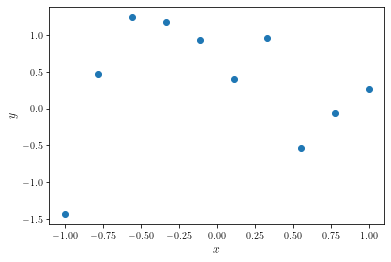

In [139]:
# function to approximate 
def f(x, noise=True):
    if noise:
        #replace with a polynomial maybe
        return np.cos(2*jnp.prod(x, axis=1))*np.exp(-x[:,0]) + 0.4*np.random.randn(x.shape[0],)
    else:
        return np.cos(2*jnp.prod(x, axis=1))*np.exp(-x[:,0]) 
# example in one dimension
x = jnp.linspace(-1,1,10).reshape(-1,1)
y = f(x)
print(x.shape, y.shape)
plt.scatter(x, y)
plt.xlabel("$x$", fontsize=fontsize_label)
plt.ylabel("$y$", fontsize=fontsize_label)
plt.show()

In [140]:
class Regression(nn.Module):
    num_features: int
    
    def setup(self):
        self.w = self.param('weights', jax.nn.initializers.glorot_uniform(),
                                (self.num_features,1))
        self.shift = self.param('bias', jax.nn.initializers.glorot_uniform(),
                                (1,1))
    @nn.compact
    def __call__(self, x):
        out = jnp.sum(x*self.w[:,0], axis=1)
        return out + self.shift
# initializing the optimizer
learning_rate = 1e-3
optx = optax.adam(learning_rate=learning_rate)
# A function to generate polynomial features - equivalent to fitting using a polynomial 
def generate_poly(deg_poly, x):
    poly = PolynomialFeatures(deg_poly)
    return poly.fit_transform(x)


## Fitting using a affine mappings

In [141]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
print(x_train.shape, y_train.shape)
# initialize the neural network 
model_linear = Regression(1)
params = model.init(jax.random.PRNGKey(0), x_test)
opt_state = optx.init(params)

# define the loss function 
@jax.jit
def MSE(params, x, y_true):
    y_pred = model.apply(params, x)
    return jnp.mean((y_pred-y_true)**2)

loss_fn = MSE
loss_grad_fn = jax.value_and_grad(MSE) # a function to evaluate the function and its gradient)

# training loop
n_epochs = 2000 #number of training epochs 
for e in range(n_epochs):
    loss_val, grad = loss_grad_fn(params, x_train, y_train)
    updates, opt_state = optx.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    if e % 100 == 0:
        print(f"epoch: {e}, loss function: {loss_val}")

(6, 1) (6,)
epoch: 0, loss function: 0.6419569253921509
epoch: 100, loss function: 0.5222498774528503
epoch: 200, loss function: 0.4272277057170868
epoch: 300, loss function: 0.35356244444847107
epoch: 400, loss function: 0.2978641092777252
epoch: 500, loss function: 0.2569217085838318
epoch: 600, loss function: 0.22776201367378235
epoch: 700, loss function: 0.20771056413650513
epoch: 800, loss function: 0.19444426894187927
epoch: 900, loss function: 0.18602785468101501
epoch: 1000, loss function: 0.18092447519302368
epoch: 1100, loss function: 0.17797520756721497
epoch: 1200, loss function: 0.17635536193847656
epoch: 1300, loss function: 0.17551189661026
epoch: 1400, loss function: 0.17509643733501434
epoch: 1500, loss function: 0.17490336298942566
epoch: 1600, loss function: 0.17481878399848938
epoch: 1700, loss function: 0.1747843325138092
epoch: 1800, loss function: 0.17477063834667206
epoch: 1900, loss function: 0.17476743459701538


Plot the learned function.

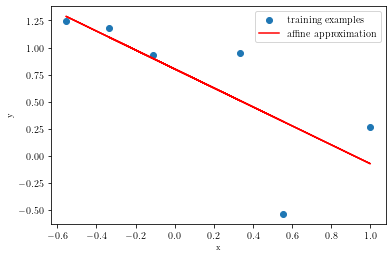

In [142]:
plt.scatter(x_train[:,0], y_train, label="training examples")
plt.xlabel("x", fontsize=fontsize_legend)
plt.ylabel("y", fontsize=fontsize_legend)
params_linear = params
ypred_train = model.apply(params_linear, x_train)
plt.plot(x_train, ypred_train.T, color='r', label="affine approximation")
plt.legend()
plt.show()

Evaluate the training error. What do you deduce?

In [143]:

deg_poly = 50 #degree of the polynomial
x_poly = generate_poly(deg_poly, x)
scaler = preprocessing.StandardScaler().fit(x_poly)
x_poly = scaler.transform(x_poly)
x_train, x_test, y_train, y_test = train_test_split(x_poly, y, test_size=0.33, random_state=42)

# initialize the neural network 
model_nonlinear = Regression(deg_poly + 1)
params = model_nonlinear.init(jax.random.PRNGKey(0), x_test)
opt_state = optx.init(params)

# define the loss function 
@jax.jit
def MSE(params, x, y_true):
    y_pred = model_nonlinear.apply(params, x)
    return jnp.mean((y_pred-y_true)**2)

loss_fn = MSE
loss_grad_fn = jax.value_and_grad(MSE) # a function to evaluate the function and its gradient)

# training loop
n_epochs = 5000 #number of training epochs 
for e in range(n_epochs):
    loss_val, grad = loss_grad_fn(params, x_train, y_train)
    updates, opt_state = optx.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    if e % 100 == 0:
        print(f"epoch: {e}, loss function: {loss_val}")

epoch: 0, loss function: 0.9041492342948914
epoch: 100, loss function: 0.32868778705596924
epoch: 200, loss function: 0.24827533960342407
epoch: 300, loss function: 0.1896575689315796
epoch: 400, loss function: 0.1466103196144104
epoch: 500, loss function: 0.11554824560880661
epoch: 600, loss function: 0.0935329720377922
epoch: 700, loss function: 0.07810857892036438
epoch: 800, loss function: 0.06731182336807251
epoch: 900, loss function: 0.0596659779548645
epoch: 1000, loss function: 0.054127611219882965
epoch: 1100, loss function: 0.04999799653887749
epoch: 1200, loss function: 0.046824611723423004
epoch: 1300, loss function: 0.044315457344055176
epoch: 1400, loss function: 0.042276374995708466
epoch: 1500, loss function: 0.040571779012680054
epoch: 1600, loss function: 0.03910257667303085
epoch: 1700, loss function: 0.03779470920562744
epoch: 1800, loss function: 0.03659301996231079
epoch: 1900, loss function: 0.03545735776424408
epoch: 2000, loss function: 0.03435974195599556
epoc

We now evaluate the training and test error. Does the model suffer from overfitting? from underfitting? from both?

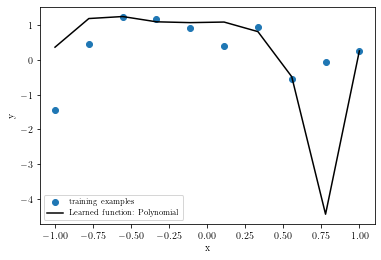

In [144]:
plt.scatter(x[:,0], y, label="training examples")
plt.xlabel("x")
plt.ylabel("y")
params_nonlinear = params
ypred_train = model_nonlinear.apply(params_nonlinear, x_poly)
plt.plot(x, ypred_train.T, color='black', label="Learned function: Polynomial")
plt.legend(fontsize=fontsize_legend)
plt.show()

Generate a new dataset and evaluate both hypotheses on it. What do you conclude?

ScopeParamShapeError: Initializer expected to generate shape (101, 1) but got shape (1, 1) instead for parameter "weights" in "/". (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.ScopeParamShapeError)

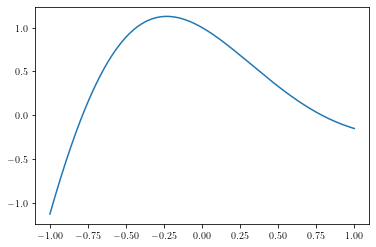

In [145]:
# plotting all functions on a bigger grid

x = jnp.linspace(-1,1,1000).reshape(-1,1)
y_true = f(x, noise=False)
plt.plot(x, y_true)
y_linear_p = model_linear.apply(params_linear, x)
plt.plot(x, y_linear_p)
y_nlinear_p = model_nonlinear.apply(params_nonlinear, x)
plt.plot(x, y_nlinear_p)